In [1]:
#install.packages("keras")
#install.packages("tfruns")
#install.packages("tfestimators")
#install.packages("dslabs")

In [2]:
rm(list=ls())

In [205]:
# Helper packages
library(readr)
library(dplyr)         # for basic data wrangling
library(ggplot2)
library(gridExtra)
library(recipes)
library(caret)

# Modeling packages
library(keras)         # for fitting DNNs
library(tfruns)        # for additional grid search & model training functions

# Modeling helper package - not necessary for reproducibility
library(tfestimators)  # provides grid search & model training interface

use_python("/home/creyesp/Projects/repos/r-course/venv/bin/python")


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Read Dataset

In [71]:
path_data = '/home/creyesp/Projects/repos/r-course/data/online_shoppers_intention.csv'

categorical = c(
    'Month',
    'VisitorType',
    'OperatingSystems',
    'Browser',
    'Region',
    'TrafficType',
    'Administrative',
    'Informational',
    'ProductRelated',
    'Weekend'
)
numerical = c(
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'SpecialDay'
)
outcome = 'Revenue'

column_parser <- cols(
    Administrative = col_character(),
    Administrative_Duration = col_double(),
    Informational = col_character(),
    Informational_Duration = col_double(),
    ProductRelated = col_character(),
    ProductRelated_Duration = col_double(),
    BounceRates = col_double(),
    ExitRates = col_double(),
    PageValues = col_double(),
    SpecialDay = col_double(),
    Month = col_character(),
    OperatingSystems = col_character(),
    Browser = col_character(),
    Region = col_character(),
    TrafficType = col_character(),
    VisitorType = col_character(),
    Weekend = col_character(),
    Revenue = col_logical()
)

data = readr::read_delim(path_data, delim=',', col_types = column_parser)

# Split train/test

In [72]:
set.seed(42)

index_train <- createDataPartition(data$Revenue, p = 0.8, list = FALSE)
intention_train <- data[index_train, ]
intention_test  <- data[-index_train, ]

head(intention_train)

Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
0,0,0,0,1,0.000000,0.20,0.20,0,0.0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64.000000,0.00,0.10,0,0.0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,2.666667,0.05,0.14,0,0.0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
0,0,0,0,10,627.500000,0.02,0.05,0,0.0,Feb,3,3,1,4,Returning_Visitor,TRUE,FALSE
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,FALSE


# Prepare data

In [73]:
prep_intention <- recipe(Revenue ~ ., data = intention_train) %>%
    step_medianimpute(all_of(numerical)) %>% 
    step_string2factor(all_of(categorical)) %>% 
    step_knnimpute(all_of(categorical)) %>% 
    step_dummy(all_of(categorical), one_hot=TRUE) %>% 
    step_normalize(all_predictors()) %>% 
    step_mutate(Revenue = as.integer(Revenue)) %>% 
    prep()
    
intention_train_clean  <-  bake(prep_intention, intention_train)
intention_test_clean  <-  bake(prep_intention, intention_test)

X_train <- as.matrix(intention_train_clean[setdiff(names(intention_train_clean), "Revenue")])
Y_train <- intention_train_clean$Revenue
X_test <- as.matrix(intention_test_clean[setdiff(names(intention_test_clean), "Revenue")])
Y_test <- intention_test_clean$Revenue

In [74]:
n_cols = ncol(X_train)
n_cols

[1] 408

# Neural Networks models (Tensorflow + keras)
Multi-Layer Perceptron / Feed Forward Neural Network
<img src="https://mk0analyticsindf35n9.kinstacdn.com/wp-content/uploads/2018/01/nural-network_3.gif">
https://analyticsindiamag.com/most-common-activation-functions-in-neural-networks-and-rationale-behind-it/

## Hiper-parametros
* **Hidden Unit**: tambien conocidas como neuronas, son una funcion que toma una entrada (ej: features o la salida de la layer anterior) y realiza la suma ponderada (regresion lineal) seguido a una funcion de activacion.
* **Activation Function**: Transforma la salidad de una neurona, generalmente es una funcion no lineal. La mas famosa de estas funciones es ReLU (Rectified Linear Units), sin embargo hay varias de la misma familia que tratan de resolver algunos problemas que tiene ReLU, PReLU (Parametric Rectified Linear Unit), ELU (Exponential Linear Units) pero un buen inicio es comanzar con ReLU. [Doc](https://tensorflow.rstudio.com/reference/keras/#section-activations)
* **Layer**: es una coleccion de neuronas que estan el mismo nivel.
* **Loss Function**: Es la funcion que se usa para medir el error del modelo con el fin de guiar a al modelo a la mejor solución.
  * Para problemas de clasificación binaria: binary cross entropy (log loss)
  * Para problemas de clasificación multiclases: categorical cross entropy
  * Para regresion: MSE/SSE
* **Batch size**: es el tamaño de observaciones que se van a pasar por la red para calcular el error con la loss funtion para actualizar los pesos de la red. Cuando tenemos dataset muy grande toma una gran ventaja porque podemos posar una pequeña muestas de los datos si tener que tener todo cargado en memoria, además valores mas grandes requiren mas recursos del sistema y valors bajos pordrian hacer el entrenamoento muy ruidoso (trade-off). [Más detalles](https://stats.stackexchange.com/questions/140811/how-large-should-the-batch-size-be-for-stochastic-gradient-descent) 
* **Optimizer**: implementacion de SDG que se usará para actualizar los pesos de la red. [full list](https://tensorflow.rstudio.com/reference/keras/#section-optimizers)
* **Learning Rate**: el paso con que SDG va a actualizar los pesos de la red.
* **Epoch**: Numero de veces que se pasa el dataset completo en el entrenamiento.
[Practical Recommendations for Gradient-Based Training ofDeepArchitectures](https://arxiv.org/pdf/1206.5533.pdf)

## Valore por defecto

Si bien no hay una regla fija ni un standard para la construccion de las redes neuronales, hay algunos valores empiricos que pueden ser usados en las fases inicales para luego ir ajustando iterativamente sobre ellos.

* **Numero de hidden units**: 128-256 puede ser un buen inicio, entre mas grande el numero de neuronas mas capaccidad tiene de aprender relaciones en los datos pero esto a su vez lleva a ser sensible a overfitting, hay que explorar subir o bajar este valor.
* **Activation Function**:  ReLU por simplicidad y eficacia.
* **Numero de layers (capas)**: 1 o 2 capas es un buen inicio, si nuestra red tiene un performance bajo quiza aumentar el numero de capas pueda ayudar a construir relaciones de los datos.
* **Optimizer**: SDG es el más clasico pero hay varias mejoras para hacer el proceso más dinamico, por ejemplo ADAM, RMSProp o configurar otros parametros de SGD como nestrov momentum.
* **Learning Rate**: 1e-3 1e-5 seems to be a good place to start. I usually start on the high-end and if the network has trouble learning (e.g. training loss doesn’t go down or bounces wildly), I’ll turn down the learning rate and try again.
* **Batch size** - Depends on problem size and GPU memory, but I typically start with 64-128
* **Epoch**: esta directamente relacionado con el learning rate, entre mas pequeño es este mayor numero de epoch vamos a necesitar para llegar el minimo del error.
* **Data Scaling** - Center and scale each column. Neural nets like data be be near 0 and not have many large values.

[Activation functions](https://dashee87.github.io/deep%20learning/visualising-activation-functions-in-neural-networks/)   
[Playground tf](https://playground.tensorflow.org/)   

[Documentación Oficial de keras en R](https://tensorflow.rstudio.com/reference/keras/)

## Modelo 1 - Base
### Topologia
Primero definimos la topologia, en otras palabrea la forma en la que se conectan las neuronas, lo cual significa decidir las distintas capas que vamos a usar en nuestra red, el numero de neuronas (units) por capa, la relacion entre ellas y cuales son las funciones de activacion que vamos a usar.

* **keras_mode_secuencial**: cada capa nueva que agregamos se conecta con la anterior secuencialmente
* **layer_dense**: es un tipo de de capa donde cada neurona esa de esa capa estan conectadas con todas las neuronas de la capa anterior y la siguiente.
  * **units**: numero de neuronas por capa
  * **activation**: funcion de activacion que vamos usar en la salida de cada neurona

Como vimos en [Playground tf](https://playground.tensorflow.org/) las primeras capas capturan informacion simple, pero a medida que ponemos mas capas y nuestra red se hace mas profunda es capaz de capturar relaciones mas complejas o de mas alto nivel

<img src="https://playground.tensorflow.org/preview.png">

In [154]:
model <- keras_model_sequential() %>%
  layer_dense(units = 128, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 1, activation = "sigmoid")

In [155]:
summary(model)

Model: "sequential_31"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_91 (Dense)                    (None, 128)                     52352       
________________________________________________________________________________
dense_92 (Dense)                    (None, 1)                       129         
Total params: 52,481
Trainable params: 52,481
Non-trainable params: 0
________________________________________________________________________________


In [156]:
408*128 + 128

[1] 52352

### Entrenar
Despues de definir la estructura de nuestra red tenemos que definir como vamoa  hacer para que la red ajuste los pesos de cada neurona, para esto necitamos alguna tecnica de optimizaccion. La funcion más clasica es SGD pero hay muchas más.
* **loss**: funcion para evaluar que tan bien lo esta haciendo el modelo, para problemas de clasificacion binaria usamos la entropia (log loss).
* **optimazer**: funcion de optimizacion para ir ajustando los pesos iterativamente en funcion del resultado de la loss
  * lr: learning rate es uno parametro del optimizador con el que controlamos el paso con el que se actualizan los pesos de la red.
* **metric**: adicionalmenete podemos agregar algunas metricas ademas de la loss para ir viendo la evolucion de niestro modelos a medida que va entrenando, de la mismas forma que lo hicimos con xgboost


In [157]:
model <- model %>% 
  compile(
    loss = 'binary_crossentropy',
    optimizer = optimizer_sgd(lr=0.01),
    metrics = c('accuracy')
  )

Despues de crear el model usamos la funcion `fit` para hacer el entrenamiento

In [158]:
set.seed(42)
history <- model %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 25,
    batch_size = 32,
    validation_split = 0.2,
    verbose = 1
  )
history


Final epoch (plot to see history):
        loss: 0.1818
    accuracy: 0.9298
    val_loss: 0.5551
val_accuracy: 0.8373 

Tensorflow te permite ver como fue la evolución de la loss u otra metrica en cada epoch para tener una idea de como la red fue aprendiendo, muy simialr las graficas con XGBoost.

`geom_smooth()` using formula 'y ~ x'



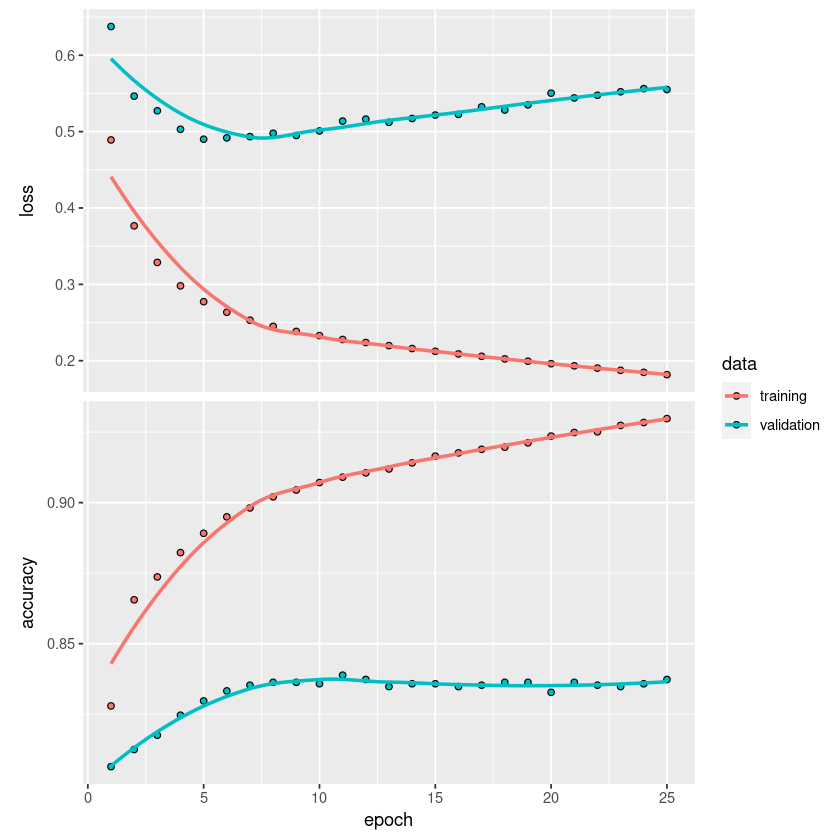

In [159]:
plot(history)

Evaluación en test

In [160]:
model %>% evaluate(X_test, Y_test, batch_size = 128)

loss  accuracy 
0.3627902 0.8819473

### Predictions

In [161]:
# Método genérico para las predicciones
predict(model, X_test, batch_size = 32)[1:5]

# Método para obtener la probabilidad de la predicción
predict_proba(model, X_test)[1:5]

# Método para obtener la clase de la predicción
predict_classes(model, X_test)[1:5]



[1] 0.0085301697 0.0002150238 0.0167428851 0.0033516288 0.0010492504

[1] 0.0085301697 0.0002150238 0.0167428851 0.0033516288 0.0010492504

[1] 0 0 0 0 0

Podemos revisar la matriz de confusion y las otras metricas de clasificacion en train y test para ver el performance del modelo

In [162]:
data_to_eval = X_train
real_target = Y_train
pred_intention <- predict(model, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8159  673
         1  179  854
                                          
               Accuracy : 0.9136          
                 95% CI : (0.9079, 0.9191)
    No Information Rate : 0.8452          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6197          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.82672         
                 Recall : 0.55927         
                     F1 : 0.66719         
             Prevalence : 0.15479         
         Detection Rate : 0.08657         
   Detection Prevalence : 0.10471         
      Balanced Accuracy : 0.76890         
                                          
       'Positive' Class : 1               
                                          

### Evaluación en test

In [163]:
data_to_eval = X_test
real_target = Y_test
pred_intention <- predict(model, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2001  208
         1   83  173
                                          
               Accuracy : 0.8819          
                 95% CI : (0.8686, 0.8944)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 1.241e-07       
                                          
                  Kappa : 0.4784          
                                          
 Mcnemar's Test P-Value : 3.621e-13       
                                          
              Precision : 0.67578         
                 Recall : 0.45407         
                     F1 : 0.54317         
             Prevalence : 0.15456         
         Detection Rate : 0.07018         
   Detection Prevalence : 0.10385         
      Balanced Accuracy : 0.70712         
                                          
       'Positive' Class : 1               
                                          

## Modelo 2

Ahora que sabemos lo basico de como construir una red podemos comenzar a crear diferentes configuraciones y ver cual es la que nos resulta mejor para resolver nuestro problema.   

Esta vez vamos a probar disminuir el numero de neuronas con el fin de forzar a la red a quedarse solo con la informacion necesaria.




Final epoch (plot to see history):
        loss: 0.1881
    accuracy: 0.9257
    val_loss: 0.5098
val_accuracy: 0.8444 

`geom_smooth()` using formula 'y ~ x'



loss  accuracy 
0.3393720 0.8791075

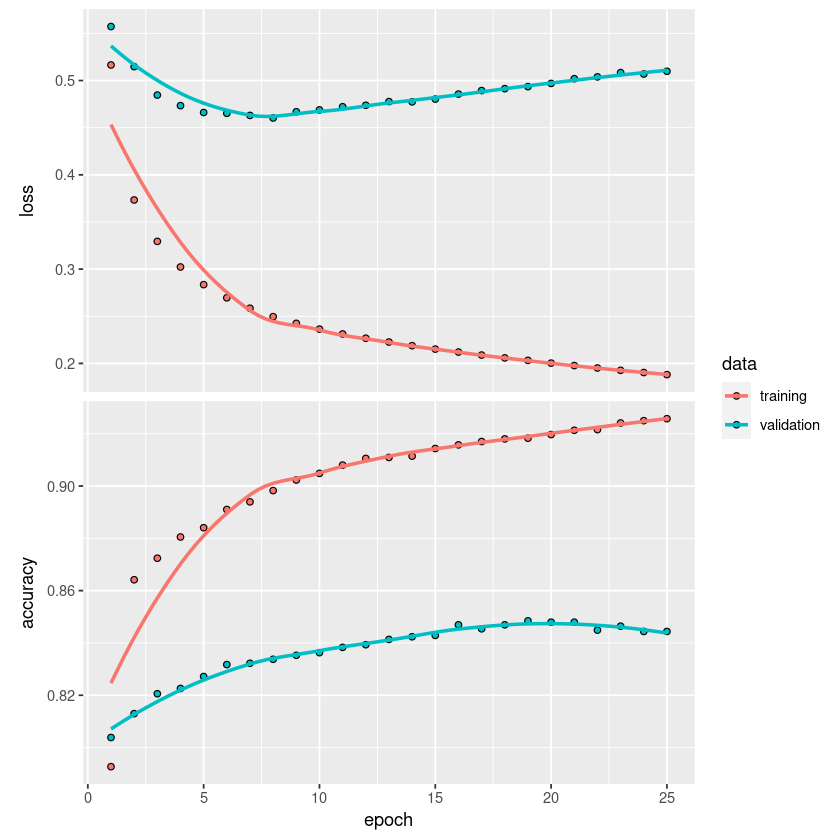

In [263]:
model_2 <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 1, activation = "sigmoid") %>% 
  compile(
    optimizer = optimizer_sgd(lr = 0.01),
    loss = 'binary_crossentropy',
    metrics = c('accuracy'),
    )

# Fit model
set.seed(42)
history <- model_2 %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 25,
    batch_size = 32,
    validation_split = 0.2,
    verbose = FALSE
  )

history

plot(history)

model_2 %>% evaluate(X_test, Y_test, batch_size = 128)

### Evaluación en test

In [264]:
data_to_eval = X_test
real_target = Y_test
pred_intention <- predict(model_2, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1994  208
         1   90  173
                                          
               Accuracy : 0.8791          
                 95% CI : (0.8656, 0.8917)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 1.065e-06       
                                          
                  Kappa : 0.4704          
                                          
 Mcnemar's Test P-Value : 1.222e-11       
                                          
              Precision : 0.65779         
                 Recall : 0.45407         
                     F1 : 0.53727         
             Prevalence : 0.15456         
         Detection Rate : 0.07018         
   Detection Prevalence : 0.10669         
      Balanced Accuracy : 0.70544         
                                          
       'Positive' Class : 1               
                                          

## Modelo 3
Ahora en podemos explorar que pasa si aumentamos el numero de neuronas.


Final epoch (plot to see history):
        loss: 0.1783
    accuracy: 0.9292
    val_loss: 0.5843
val_accuracy: 0.8332 

`geom_smooth()` using formula 'y ~ x'



loss  accuracy 
0.3635539 0.8815416

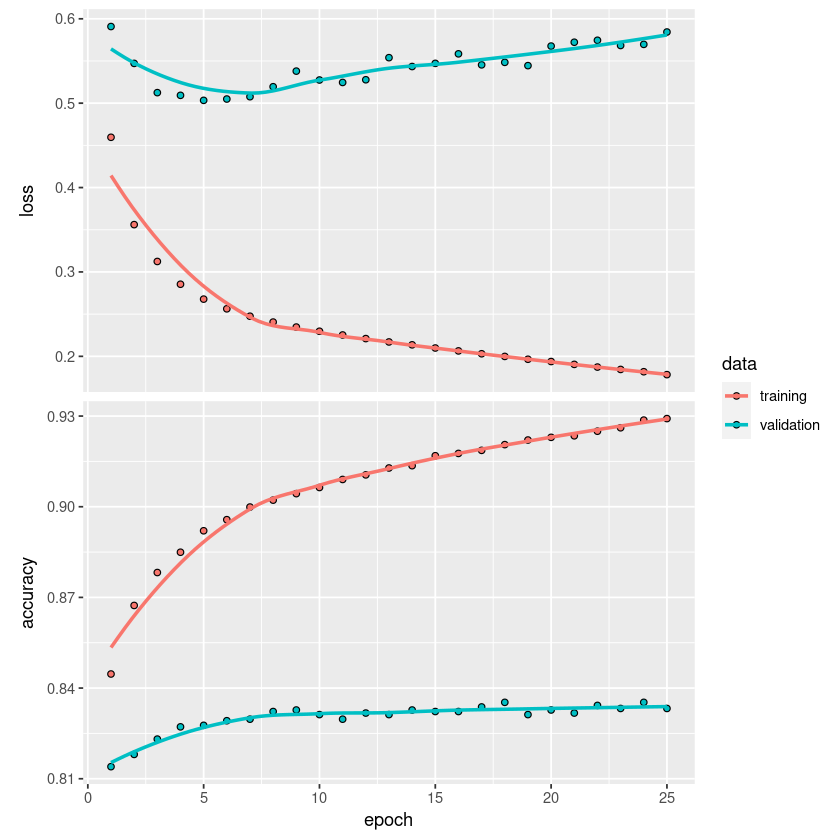

In [262]:
model_3 <- keras_model_sequential() %>%
  layer_dense(units = 256, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 1, activation = "sigmoid") %>% 
  compile(
    optimizer = optimizer_sgd(lr = 0.01),
    loss = 'binary_crossentropy',
    metrics = c('accuracy'),
    )

# Fit model
set.seed(42)
history <- model_3 %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 25,
    batch_size = 32,
    validation_split = 0.2,
    verbose = FALSE
  )

history

plot(history)

model_3 %>% evaluate(X_test, Y_test, batch_size = 128)

### Evaluacion en test

In [265]:
data_to_eval = X_test
real_target = Y_test
pred_intention <- predict(model_3, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2009  217
         1   75  164
                                         
               Accuracy : 0.8815         
                 95% CI : (0.8681, 0.894)
    No Information Rate : 0.8454         
    P-Value [Acc > NIR] : 1.706e-07      
                                         
                  Kappa : 0.4653         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
              Precision : 0.68619        
                 Recall : 0.43045        
                     F1 : 0.52903        
             Prevalence : 0.15456        
         Detection Rate : 0.06653        
   Detection Prevalence : 0.09696        
      Balanced Accuracy : 0.69723        
                                         
       'Positive' Class : 1              
                                         

## Modelo 4
Ahora podemos aumentar el numero de capas a ver si logramos capturar realciones mas complejas en los datos que con solo 1 capa no es posible.


Final epoch (plot to see history):
        loss: 0.2379
    accuracy: 0.9038
    val_loss: 0.4672
val_accuracy: 0.8338 

`geom_smooth()` using formula 'y ~ x'



loss  accuracy 
0.3408194 0.8673428

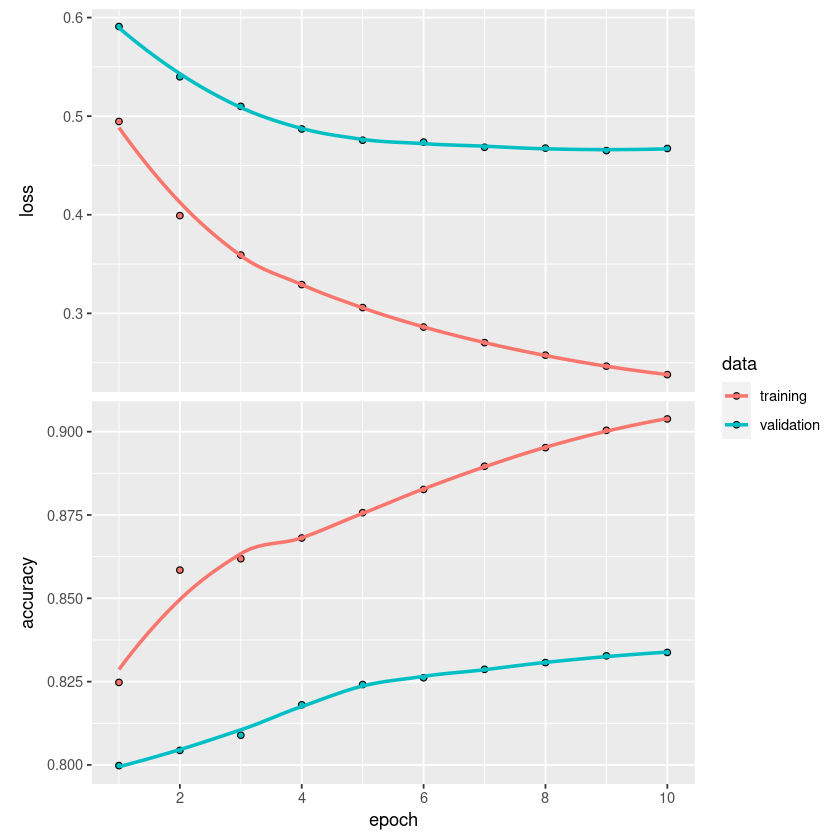

In [270]:
model_4 <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 32, activation = "relu") %>%
  layer_dense(units = 1, activation = "sigmoid") %>% 
  compile(
    optimizer = optimizer_sgd(lr = 0.01),
    loss = 'binary_crossentropy',
    metrics = c('accuracy'),
    )

# Fit model
set.seed(42)
history <- model_4 %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.2,
    #validation_data, 
    verbose = FALSE
  )

history

plot(history)

model_4 %>% evaluate(X_test, Y_test, batch_size = 128)

### Evaluación en test

In [271]:
data_to_eval = X_test
real_target = Y_test
pred_intention <- predict(model_4, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2004  247
         1   80  134
                                          
               Accuracy : 0.8673          
                 95% CI : (0.8533, 0.8805)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 0.001202        
                                          
                  Kappa : 0.3817          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.62617         
                 Recall : 0.35171         
                     F1 : 0.45042         
             Prevalence : 0.15456         
         Detection Rate : 0.05436         
   Detection Prevalence : 0.08682         
      Balanced Accuracy : 0.65666         
                                          
       'Positive' Class : 1               
                                          

## Early stop

In [233]:
model_2 <- keras_model_sequential() %>%
  layer_dense(units = 128, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 128, activation = "relu") %>%
  layer_dense(units = 1, activation = "sigmoid") %>% 
  compile(
    optimizer = optimizer_sgd(lr = 0.01),
    loss = 'binary_crossentropy',
    metrics = c('accuracy'),
    )

# Fit model
set.seed(42)
history <- model_2 %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    #callbacks = c(callback_early_stopping(patience = 10)),
    verbose = FALSE
  )

history


Final epoch (plot to see history):
        loss: 0.006979
    accuracy: 0.9996
    val_loss: 1.755
val_accuracy: 0.8191 

In [ ]:
history_data <- as.data.frame(history$metrics) %>% 
    mutate(n = row_number())
p1 <- history_data %>% 
    ggplot(aes(n, loss)) +
        geom_point(aes(color='training')) +
        geom_point(aes(n, val_loss, color='validation'))
        

p2 <- history_data %>% 
    ggplot(aes(n, accuracy)) +
        geom_point(aes(color='training')) + 
        geom_point(aes(n, val_accuracy, color='validation')) 

gridExtra::grid.arrange(p1, p2, ncol = 1)

## Mejor modelo
A pesar de las diferentes combonaciones que probamos la configuración inicial fue una de las que mejor resutlado nos dio. Quiza para mejorar el performance del modelo necesitamos mas features que puedan explicar mejor el problema y otra opcion es darle mas observaciones para que el modelo tenga mas información al momento de hacer el entrenamiento


Final epoch (plot to see history):
        loss: 0.165
    accuracy: 0.9349
    val_loss: 0.5703
val_accuracy: 0.8348 

`geom_smooth()` using formula 'y ~ x'



loss  accuracy 
0.3601997 0.8831643

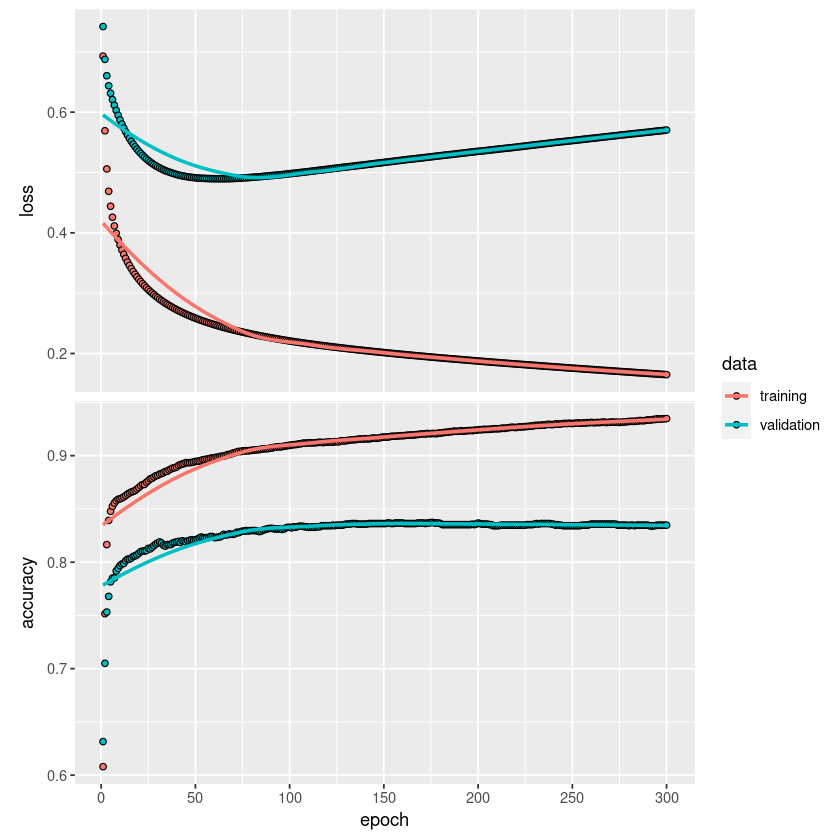

In [351]:
model_best <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = "relu", input_shape = n_cols) %>%
  layer_dense(units = 1, activation = "sigmoid") %>% 
  compile(
    optimizer = optimizer_sgd(lr = 0.001),
    loss = 'binary_crossentropy',
    metrics = c('accuracy'),
    )

# Fit model
set.seed(42)
history <- model_best %>%
  fit(
    x = X_train,
    y = Y_train,
    epochs = 300,
    batch_size = 32,
    validation_split = 0.2,
    verbose = FALSE
  )

history

plot(history)

model_best %>% evaluate(X_test, Y_test, batch_size = 32)

### Evaluación en test

In [352]:
data_to_eval = X_test
real_target = Y_test
pred_intention <- predict(model_best, data_to_eval)

confusionMatrix(data = as.factor(ifelse(pred_intention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1991  195
         1   93  186
                                          
               Accuracy : 0.8832          
                 95% CI : (0.8698, 0.8956)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 4.668e-08       
                                          
                  Kappa : 0.498           
                                          
 Mcnemar's Test P-Value : 2.657e-09       
                                          
              Precision : 0.66667         
                 Recall : 0.48819         
                     F1 : 0.56364         
             Prevalence : 0.15456         
         Detection Rate : 0.07546         
   Detection Prevalence : 0.11318         
      Balanced Accuracy : 0.72178         
                                          
       'Positive' Class : 1               
                                          

# ANN en imagenes
Las redes neuronales no son muy famosas en data tabular porque otras tecnicas como RF o XGBoost obtienen mejores resultados en dataset pequeños y medianos, pero en el caso de datos no estructurados y mas complejos como las imagenes, audio y lenguajes las redes neuronales han tenido un desempeño excepcional.

In [340]:
#loading the keras inbuilt mnist dataset
data<-dataset_mnist()

#separating train and test file
train_x<-data$train$x
train_y<-data$train$y
test_x<-data$test$x
test_y<-data$test$y

rm(data)

In [341]:
dim(train_x)

[1] 60000    28    28

[1] 0

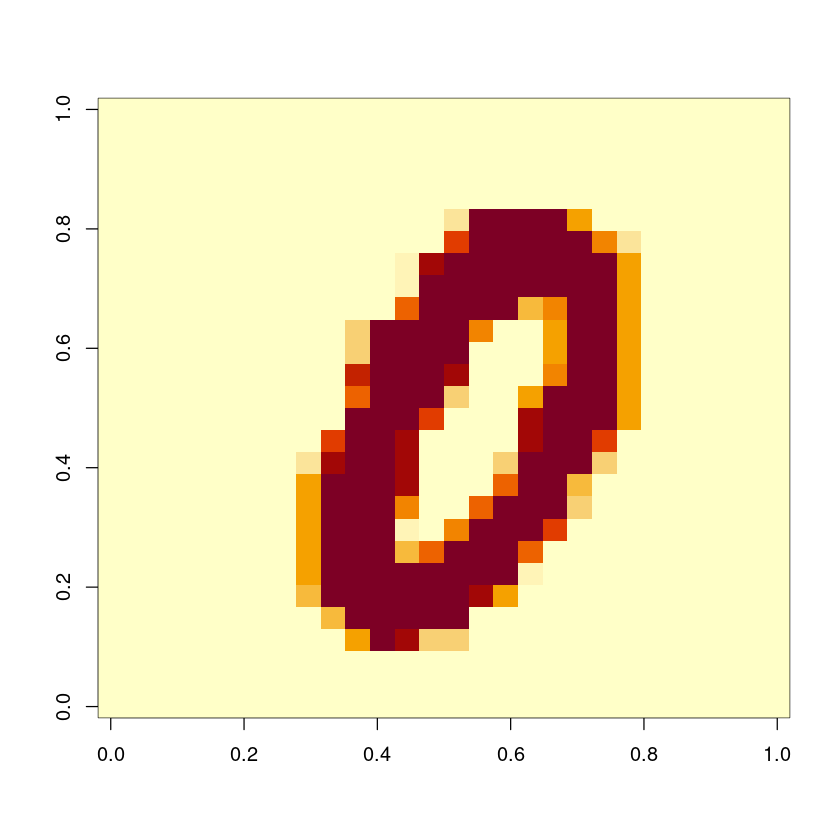

In [342]:
idx <- 35
train_y[idx]
num_img <- train_x[idx,28:1,1:28]

image(t(num_img))

Con el objetivo de usar nuestra red neuronal necesitamos pasar la imagen 2D a un vector 1D y escalar la data entre 0 y 1. 

In [343]:
train_x <- array(train_x, dim = c(dim(train_x)[1], prod(dim(train_x)[-1]))) / 255
test_x <- array(test_x, dim = c(dim(test_x)[1], prod(dim(test_x)[-1]))) / 255

Keras tiene una funcion para pasar las distintas etiquetas de un problema de multicategorias a un vector de valores unicos que es un requisito del formato de salida del modelo.

In [344]:
train_y<-to_categorical(train_y,10)
test_y<-to_categorical(test_y,10)

In [345]:
dim(train_y)

[1] 60000    10

In [346]:
model_img  <- keras_model_sequential() %>% 
  layer_dense(units = 784, input_shape = 784, activation = 'relu') %>%
  layer_dense(units = 10, activation = 'softmax') %>% 
  compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = c('accuracy')
  )


history <- model_img %>% fit(train_x, train_y, epochs = 40, batch_size = 128)

model_img %>% evaluate(test_x, test_y, batch_size = 128)

loss   accuracy 
0.07349837 0.98559999

`geom_smooth()` using formula 'y ~ x'



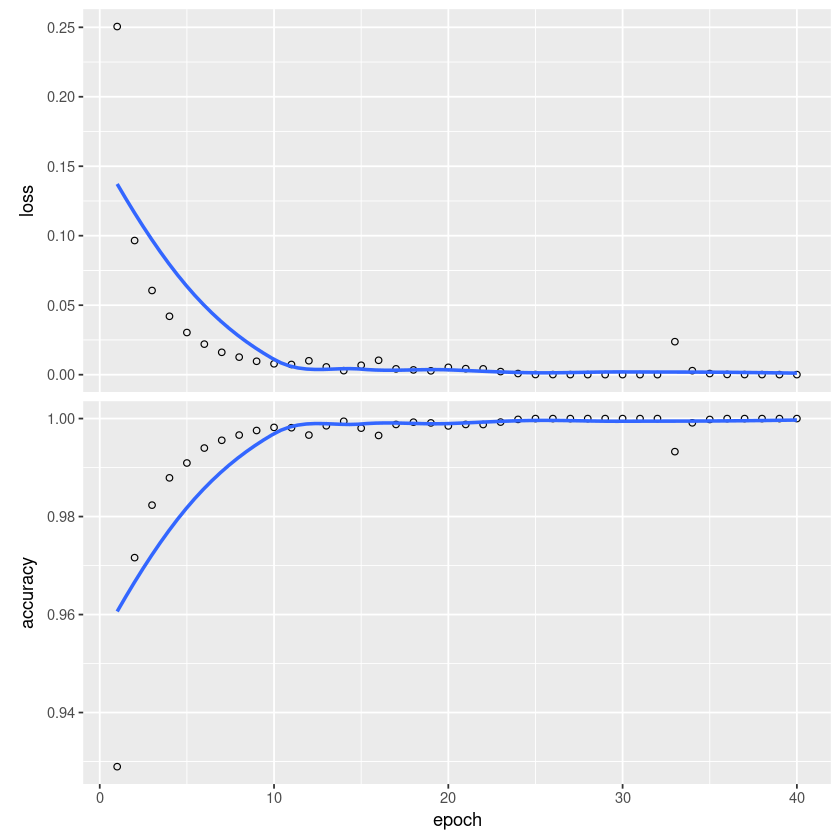

In [347]:
plot(history)

In [346]:
model_img  <- keras_model_sequential() %>% 
  layer_dense(units = 784, input_shape = 784, activation = 'relu') %>%
  layer_dense(units = 1024, input_shape = 784, activation = 'relu') %>%
  layer_dense(units = 10, activation = 'softmax') %>% 
  compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = c('accuracy')
  )


history <- model_img %>% fit(train_x, train_y, epochs = 40, batch_size = 128)

model_img %>% evaluate(test_x, test_y, batch_size = 128)

loss   accuracy 
0.07349837 0.98559999

`geom_smooth()` using formula 'y ~ x'



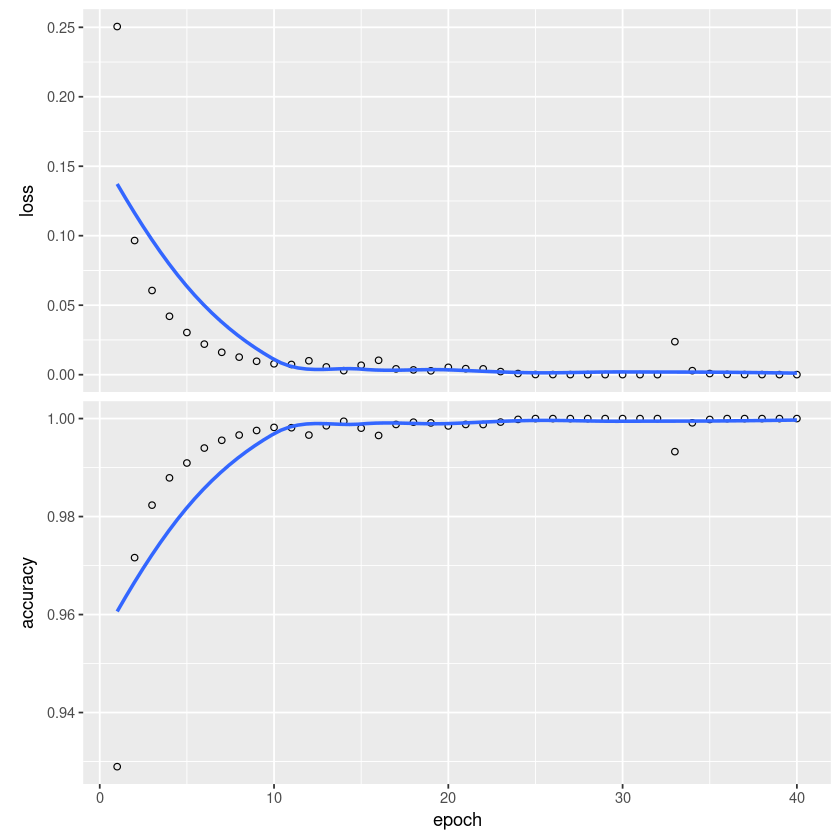

In [347]:
plot(history)

# Resumen
* Normalizar la data
* Denifir la topologia de la red
* Elegir el oprimizador 
* Entrenar
* Experimentar con los hiper-parametros

# Neural Network Zoo
<img src="https://www.asimovinstitute.org/wp-content/uploads/2019/04/NeuralNetworkZoo20042019.png">